In [482]:
#Bibliotecas que serão utilizadas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [483]:
#Lê o dataset e transforma num dataframe do pandas
df=pd.read_csv('star_classification.csv')
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


In [484]:
#Transforma a coluna de classe em valor númerico para facilitar
df["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in df["class"]]

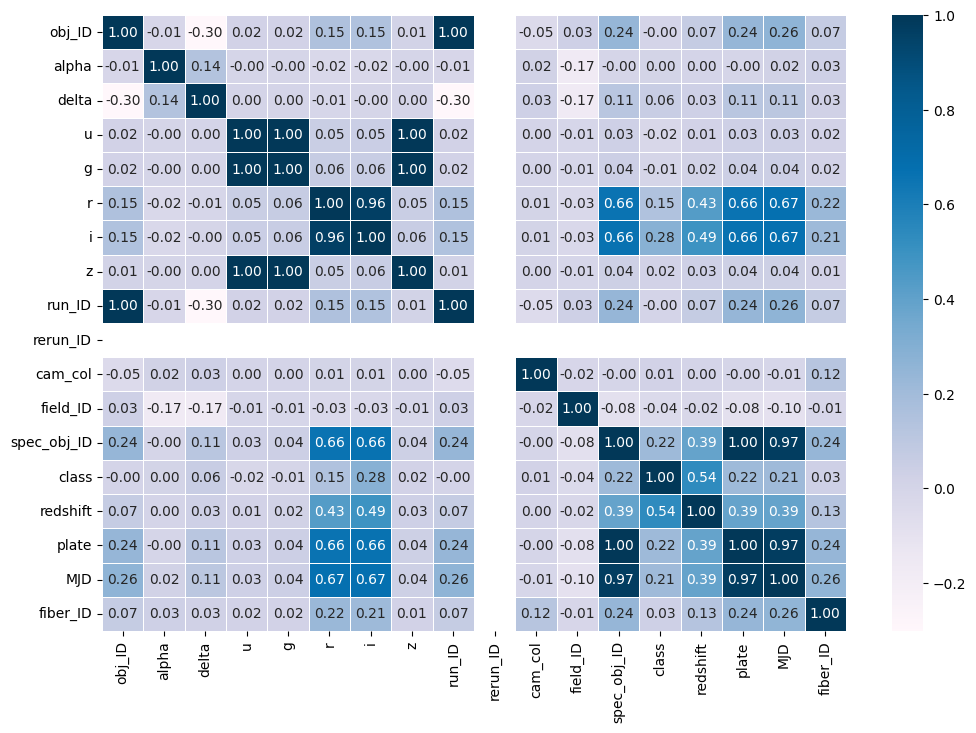

In [485]:
# Cria um gráfico de correlação entre os dados
import seaborn as sns
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.corr(), cmap="PuBu", annot=True, linewidths=0.5, fmt= '.2f',ax=ax)
plt.show()

In [486]:
#Com base no gráfico acima, selecionaremos as colunas com maior correlação ao valor da classe (nosso objetivo) 
df = df.drop(['obj_ID', 'alpha','delta','run_ID','rerun_ID','cam_col','field_ID','fiber_ID'], axis = 1)
# iterar pelas colunas do DataFrame
for col in df.columns:
    # calcular o limite superior e inferior para detecção de outliers
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lim_sup = Q3 + 1.5 * IQR
    lim_inf = Q1 - 1.5 * IQR
    #dropa outliers
    df.drop(df[df[col]<lim_inf].index, inplace=True)
    df.drop(df[df[col]>lim_sup].index, inplace=True)


df.describe()                             

,u,g,r,i,z,spec_obj_ID,class,redshift,plate,MJD
count,90600.000000,90600.000000,90600.000000,90600.000000,90600.000000,9.060000e+04,90600.000000,90600.000000,90600.000000,90600.000000
mean,22.122940,20.610919,19.548934,18.948135,18.617960,5.599462e+18,0.457494,0.393636,4973.213179,55488.705817
std,2.292251,2.079669,1.854225,1.716269,1.709973,3.307767e+18,0.684315,0.387714,2937.870994,1814.000877
min,15.358420,14.318450,13.990440,13.862170,13.805350,2.995191e+17,0.000000,-0.009971,266.000000,51608.000000
25%,20.279778,18.782877,17.908797,17.515310,17.269245,2.675189e+18,0.000000,0.027621,2376.000000,54115.000000
50%,22.283920,21.101585,19.993675,19.259345,18.860795,5.346991e+18,0.000000,0.344860,4749.000000,55806.000000
75%,23.797950,22.194750,20.961278,20.176482,19.724230,8.068239e+18,1.000000,0.602142,7166.000000,56683.000000
max,28.618680,26.817360,25.377300,24.371220,23.592280,1.412694e+19,2.000000,1.676667,12547.000000,58932.000000


In [487]:
#classifica as colunas
x = df[["u", "g", "r", "i", "z", "spec_obj_ID", "redshift", "plate", "MJD"]]
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=12)

In [488]:
#Treina o multilayer perceptron classificador e realiza os testes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = MLPClassifier(
    hidden_layer_sizes=(10, 20),
    random_state=5,
    learning_rate_init=0.01,
    max_iter=100,
)

clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)

Acurácia: 97.03%
R2 Score: 0.7923034928335763


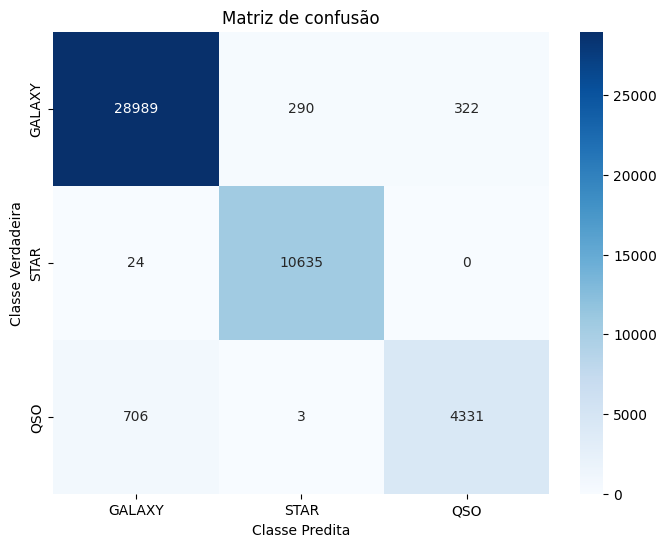

In [489]:

print(f'Acurácia: {round(accuracy_score(y_test, y_pred) * 100, 2)}%')
print("R2 Score:", round(r2_score(y_test, y_pred), 2))

cm = confusion_matrix(y_test, y_pred)
class_labels = np.unique(y)
# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["GALAXY", "STAR", "QSO"], yticklabels=["GALAXY", "STAR", "QSO"])
# Add labels and title
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de confusão')

# Show the plot
plt.show()